In [1]:
import pandas as pd
import os
import time
import copy

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

from tqdm.notebook import tqdm

plt.style.use('dark_background')

In [2]:
RANDOM_STATE = 42
BATCH_SIZE = 16

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используем устройство: {device}")

Используем устройство: cuda


## Загрузка данных и первичный анализ

### Загрузка данных

Загрузим аннотации

In [3]:
DATA_DIR = 'data/data/export'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, '_annotations.csv')

annotations_df = pd.read_csv(ANNOTATIONS_FILE)

Посмотрим на структуру

In [4]:
display(annotations_df.head())
annotations_df.info()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,291,247,370,331
1,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,pedestrian,270,235,293,321
2,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,0,266,13,327
3,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,25,258,106,304
4,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,111,259,135,289


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194539 entries, 0 to 194538
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  194539 non-null  object
 1   width     194539 non-null  int64 
 2   height    194539 non-null  int64 
 3   class     194539 non-null  object
 4   xmin      194539 non-null  int64 
 5   ymin      194539 non-null  int64 
 6   xmax      194539 non-null  int64 
 7   ymax      194539 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 11.9+ MB


Подсчитаем количество классов

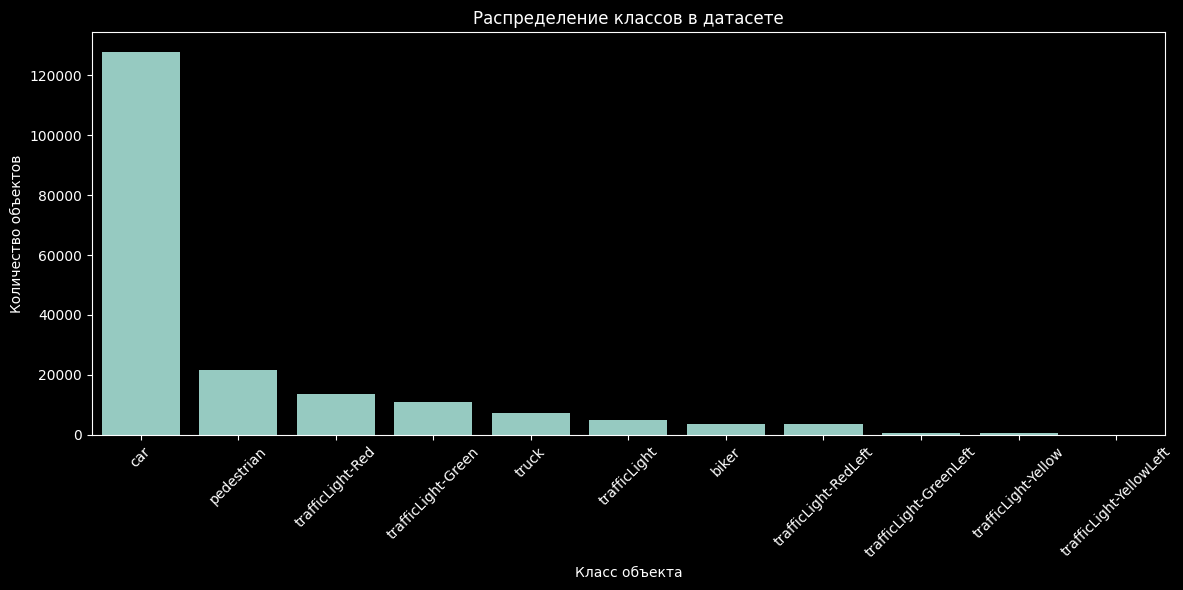

In [5]:
plt.figure(figsize=(12, 6))

class_counts = annotations_df['class'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=45)
plt.title('Распределение классов в датасете')
plt.xlabel('Класс объекта')
plt.ylabel('Количество объектов')
plt.tight_layout()

Классовый дисбаланс и избыточная детализация — главные проблемы нашего датасета. Мы имеем огромное количество экземпляров класса 'car' и очень мало экземпляров редких классов, что создает проблему "длинного хвоста" и излишней гранулярности, особенно заметной на примере светофоров.

### Упрощение и очистка данных

Сейчас нам важно не определить цвет светофора, а научить модель его находить, создав единый класс traffic_light для борьбы с классовым дисбалансом и построения надёжного фундамента. На первом этапе решим более простую задачу детекции, а затем перейдём к более сложной задаче классификации цвета.

In [6]:
traffic_classes = ['trafficLight-Red', 'trafficLight', 'trafficLight-Green', 'trafficLight-RedLeft',
                    'trafficLight-GreenLeft', 'trafficLight-Yellow',
                    'trafficLight-YellowLeft']

annotations_df.loc[annotations_df['class'].isin(traffic_classes), 'class'] = 'traffic_light'

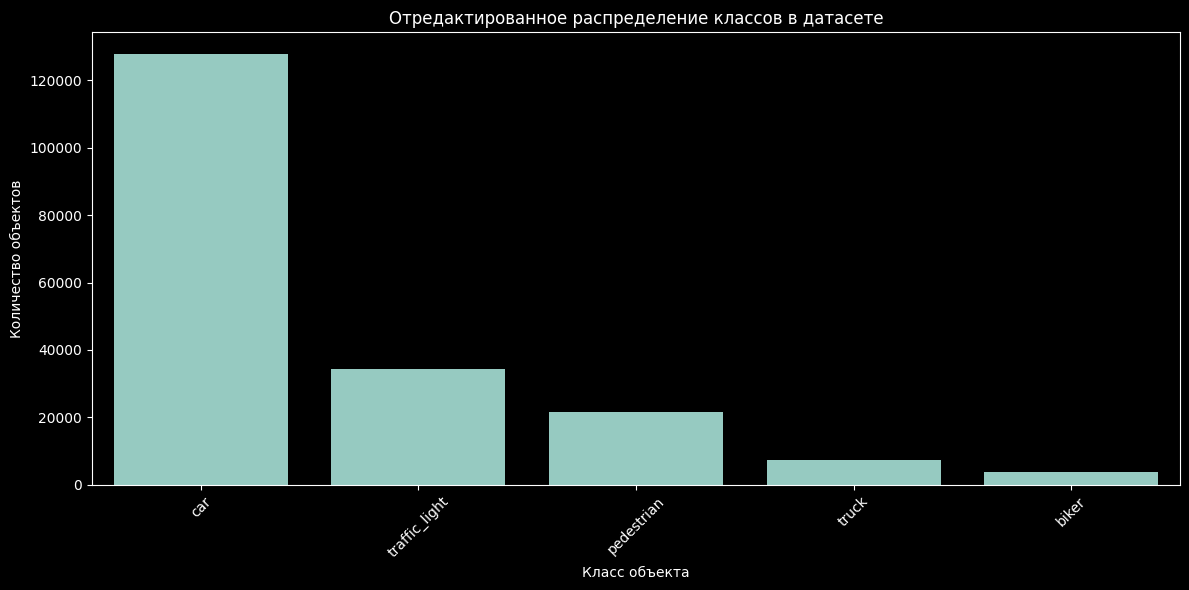

In [7]:
plt.figure(figsize=(12, 6))

class_counts_2 = annotations_df['class'].value_counts()
sns.barplot(x=class_counts_2.index, y=class_counts_2.values)
plt.xticks(rotation=45)
plt.title('Отредактированное распределение классов в датасете')
plt.xlabel('Класс объекта')
plt.ylabel('Количество объектов')
plt.tight_layout()

### Подготовка данных к созданию Dataset

Создадим словарь, который сопоставит каждому уникальному имени класса уникальную числовую метку.

In [8]:
class_names = list(class_counts_2.index)
class_to_int = {name: i + 1 for i, name in enumerate(class_names)}

class_to_int

{'car': 1, 'traffic_light': 2, 'pedestrian': 3, 'truck': 4, 'biker': 5}

Создадим новую колонку class_id в DataFrame

In [9]:
annotations_df['class_id'] = annotations_df['class'].map(class_to_int)
annotations_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,class_id
0,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,291,247,370,331,1
1,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,pedestrian,270,235,293,321,3
2,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,0,266,13,327,1
3,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,25,258,106,304,1
4,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,111,259,135,289,1


Сгруппируем данные в новый датафрейм image_annotations так, чтобы одному изображению соответствовала только одна строка

In [10]:
cols_to_agg = ['xmin', 'ymin', 'xmax', 'ymax', 'class_id']

image_annotations = (
    annotations_df
    .groupby('filename')[cols_to_agg]
    .agg(list)
    .reset_index()
)

image_annotations.head()

,filename,xmin,ymin,xmax,ymax,class_id
0,1478019952686311006_jpg.rf.54e2d12dbabc46be3c7...,"[218, 229, 253, 466]","[243, 246, 245, 206]","[226, 241, 268, 485]","[257, 260, 264, 318]","[4, 1, 1, 3]"
1,1478019952686311006_jpg.rf.JLSB3LP2Q4RuGHYKqfF...,"[218, 229, 253, 466]","[243, 246, 245, 206]","[226, 241, 268, 485]","[257, 260, 265, 317]","[4, 1, 1, 3]"
2,1478019953180167674_jpg.rf.8a816c9d7e9b423a63e...,"[198, 206, 387, 232]","[246, 251, 218, 250]","[207, 217, 445, 247]","[262, 264, 262, 270]","[4, 1, 4, 1]"
3,1478019953180167674_jpg.rf.azslsZnM8FLQPu3QWLT...,"[198, 206, 387, 233]","[246, 251, 218, 250]","[207, 217, 445, 247]","[262, 264, 262, 270]","[4, 1, 4, 1]"
4,1478019953689774621_jpg.rf.2e4b7ae29c3379da128...,"[126, 183, 191, 220, 411, 439]","[251, 242, 247, 248, 209, 213]","[129, 194, 204, 235, 448, 493]","[263, 264, 266, 267, 260, 254]","[3, 4, 1, 1, 1, 1]"


## Подготовка данных

Создадим свой класс Dataset, так как задачи детекции очень вариативны и нет отдельной функции, которая могла бы правильно собрать все наши данные

In [11]:
class RoadObjectDataset(Dataset):
    def __init__(self, annotations_df, image_dir, transforms=None):
        super().__init__()
        self.annotations = annotations_df
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        image_record = self.annotations.iloc[idx]
        image_filename = image_record['filename']

        image_path = os.path.join(self.image_dir, image_filename)

        image = cv2.imread(image_path)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        xmins = image_record['xmin']
        ymins = image_record['ymin']
        xmaxs = image_record['xmax']
        ymaxs = image_record['ymax']
        labels = image_record['class_id']

        bboxes = [[xmin, ymin, xmax, ymax] for xmin, ymin, xmax, ymax in zip(xmins, ymins, xmaxs, ymaxs)]
        
        bboxes = np.array(bboxes)
        labels = np.array(labels)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=bboxes, labels=labels)
            
            image = transformed['image'] 
            
            if len(transformed['bboxes']) > 0:
                bboxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
                labels = torch.tensor(transformed['labels'], dtype=torch.int64)
            else:
                bboxes = torch.zeros((0, 4), dtype=torch.float32)
                labels = torch.zeros(0, dtype=torch.int64)

        else:
            image = torch.from_numpy(image).permute(2, 0, 1) / 255.0
            bboxes = torch.tensor(bboxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {'boxes': bboxes, 'labels': labels}

        return image, target


Создадим пайплайн для аугментации в Albumentations, так как аугментации для детекции объектов должны одновременно изменять и изображение, и координаты bounding box'ов

In [12]:
train_transforms = A.Compose(
    [
        A.Resize(height=512, width=512, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(p=0.2),
        A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0, p=1.0),
        A.ToTensorV2(p=1.0)
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
)

val_transforms = A.Compose(
    [
        A.Resize(height=512, width=512, p=1.0),
        A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0, p=1.0),
        A.ToTensorV2(p=1.0)
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
)

c:\Users\79104\anaconda3\envs\road_detector\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Проверим работоспособность нашего класса, а также пайплайна аугментации

In [13]:
IMAGE_DIR = 'data/data/export'

train_dataset = RoadObjectDataset(
    annotations_df=image_annotations,
    image_dir=IMAGE_DIR, 
    transforms=train_transforms
)
image_tensor, target = train_dataset[0]

print(f'Длина тренировочного датасета: {len(train_dataset)}')
print(f"Размер тензора изображения: {image_tensor.shape}")
print("Содержимое target:")
print(target)

Длина тренировочного датасета: 26300
Размер тензора изображения: torch.Size([3, 512, 512])
Содержимое target:
{'boxes': tensor([[218., 243., 226., 257.],
        [229., 246., 241., 260.],
        [253., 245., 268., 264.],
        [466., 206., 485., 318.]]), 'labels': tensor([4, 1, 1, 3])}


Напишем функцию, которая сможет взять тензор изображения и target и нарисовать на картинке bounding box'ы

In [14]:
def visualize_sample(image_tensor, target):
    """
    Визуализирует тензор изображения с его bounding box'ами.
    """

    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 255).astype(np.uint8)

    image_to_draw = image_np.copy()
    for box, label in zip(target['boxes'], target['labels']):
        xmin, ymin, xmax, ymax = box.int().numpy()

        cv2.rectangle(image_to_draw, (xmin, ymin), (xmax, ymax), color=(255, 0, 0), thickness=2)
        cv2.putText(
            image_to_draw,
            str(label.item()),
            (xmin, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.9,
            (255, 0, 0),
            2
        )
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image_to_draw)
    plt.axis('off')
    plt.show()

Посмотрим, как справилась функция с обозначением объектов

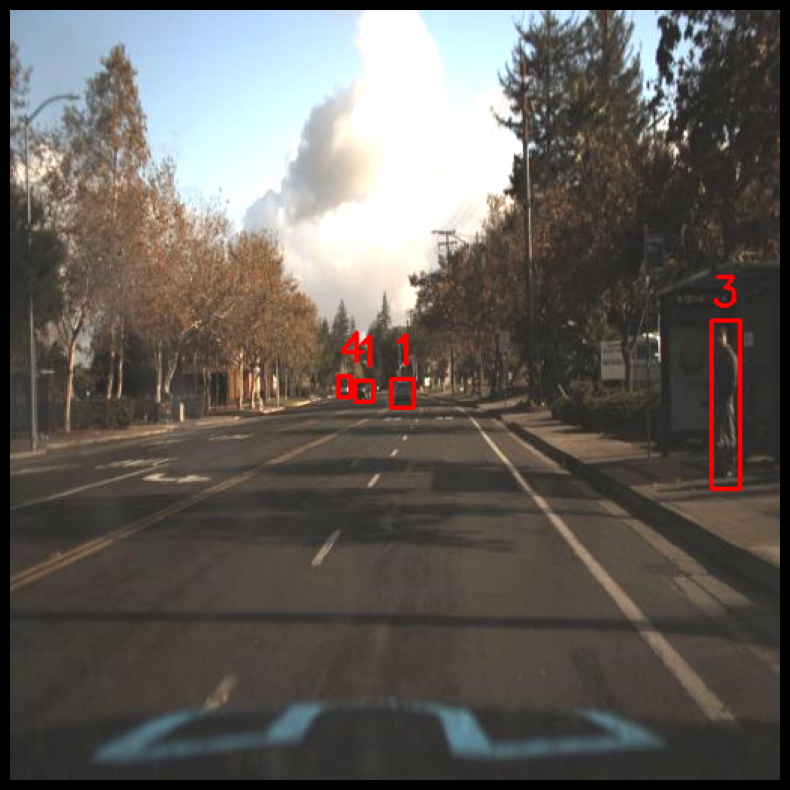

In [15]:
visualize_sample(image_tensor, target)

Отлично, все объекты были правильно выделены, а значит:
- Наш Dataset правильно прочитал изображение
- Он правильно извлек аннотации
- Он передал их в Albumentations
- Albumentations применил аугментации и корректно трансформировал bounding box'ы
- Наша функция visualize_sample правильно все отобразила

## Построение модели и обучение

В качестве готовой предобученной модели выберем fasterrcnn_mobilenet_v3_large_fpn - быстрая и достаточно точная

In [16]:
model = fasterrcnn_mobilenet_v3_large_fpn(weights='DEFAULT')

In [17]:
in_features = model.roi_heads.box_predictor.cls_score.in_features

num_classes = annotations_df['class_id'].nunique() + 1
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.roi_heads.box_predictor
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

Определим оптимизатор модели

In [18]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = optim.Adam(params, lr=0.001)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',      
    factor=0.1,      
    patience=2,      
    verbose=True   
)

c:\Users\79104\anaconda3\envs\road_detector\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Разобьём датасет на тренировочную и тестовую выборки

In [19]:
train_df, val_df = train_test_split(
    image_annotations,
    test_size=0.2,
    random_state=RANDOM_STATE
)
print(f"Размер тренировочной выборки: {len(train_df)}")
print(f"Размер валидационной выборки: {len(val_df)}")

Размер тренировочной выборки: 21040
Размер валидационной выборки: 5260


In [20]:
def collate_fn(batch):
    """
    Правильно "собирает" батч для задачи детекции.
    Возвращает кортеж из списка тензоров изображений и списка словарей target.
    """
    return tuple(zip(*batch))

Определим датасеты

In [21]:
train_dataset = RoadObjectDataset(
    annotations_df=train_df,
    image_dir=IMAGE_DIR,
    transforms=train_transforms
)

val_dataset = RoadObjectDataset(
    annotations_df=val_df,
    image_dir=IMAGE_DIR,
    transforms=val_transforms
)

In [22]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

Проверим, что всё работает - попробуем взять один батч

In [23]:
images, targets = next(iter(train_loader))

print(f"Длина батча изображений: {len(images)}")
print(f"Тип первого элемента в батче изображений: {type(images[0])}")
print(f"Форма первого тензора изображения: {images[0].shape}")
print("-" * 30)
print(f"Длина батча таргетов: {len(targets)}")
print(f"Тип первого элемента в батче таргетов: {type(targets[0])}")
print(f"Ключи в первом таргете: {targets[0].keys()}")

Длина батча изображений: 16
Тип первого элемента в батче изображений: <class 'torch.Tensor'>
Форма первого тензора изображения: torch.Size([3, 512, 512])
------------------------------
Длина батча таргетов: 16
Тип первого элемента в батче таргетов: <class 'dict'>
Ключи в первом таргете: dict_keys(['boxes', 'labels'])


### Обучение и валидация модели

Напишем функции для обучения и валидации модели на 1 эпохе

In [24]:
def train_one_epoch(model, optimizer, data_loader, device, scaler):
    model.train()
    total_loss = 0.0

    progress_bar = tqdm(data_loader, desc='Training')
    for images, targets in progress_bar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        
        loss_value = losses.item()
        total_loss += loss_value
        
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        # losses.backward()
        # optimizer.step()

        progress_bar.set_postfix(loss=loss_value)
    
    avg_loss = total_loss / len(data_loader)
    print(f"Эпоха обучения завершена. Средний лосс: {avg_loss:.4f}")

In [25]:
def evaluate(model, data_loader, device):
    model.eval()
    
    metric = MeanAveragePrecision(box_format='xyxy', backend='faster_coco_eval').to(device)
    
    progress_bar = tqdm(data_loader, desc="Validation")
    with torch.no_grad():
        for images, targets in progress_bar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            predictions = model(images)
            metric.update(predictions, targets)

    results = metric.compute()
    print(f"Результаты валидации: {results}")
    
    return results

In [26]:
def run_training(model, optimizer, scheduler, num_epochs=10):
    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_map = 0.0
    scaler = GradScaler()
    
    history = {'train_loss': [], 'val_map': []}

    for epoch in range(num_epochs):
        print(f'--- Эпоха {epoch + 1}/{num_epochs} ---')

        avg_train_loss = train_one_epoch(model, optimizer, train_loader, device, scaler)
        history['train_loss'].append(avg_train_loss)

        val_results = evaluate(model, val_loader, device)
        epoch_map = val_results['map'].item()
        history['val_map'].append(epoch_map)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1} MAP: {epoch_map:.4f} LR: {current_lr:.6f}")

        scheduler.step(epoch_map)


        if epoch_map > best_map:
            print(f"Новый лучший результат! MAP улучшился с {best_map:.4f} до {epoch_map:.4f}. Сохраняем модель.")
            best_map = epoch_map
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_detector_model.pth')
        
        print()

    time_elapsed = time.time() - start_time
    print(f'Обучение завершено за {time_elapsed // 60:.0f}м {time_elapsed % 60:.0f}с')
    print(f'Лучший mAP на валидации: {best_map:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [27]:
model, history = run_training(model, optimizer, scheduler, num_epochs=5)

--- Эпоха 1/5 ---


C:\Users\79104\AppData\Local\Temp\ipykernel_15552\1539855858.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training:   0%|          | 0/1315 [00:00<?, ?it/s]

C:\Users\79104\AppData\Local\Temp\ipykernel_15552\3864523079.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Эпоха обучения завершена. Средний лосс: 0.6100


Validation:   0%|          | 0/329 [00:00<?, ?it/s]

Результаты валидации: {'map': tensor(0.2009), 'map_50': tensor(0.4447), 'map_75': tensor(0.1557), 'map_small': tensor(0.1030), 'map_medium': tensor(0.2740), 'map_large': tensor(0.5111), 'mar_1': tensor(0.1412), 'mar_10': tensor(0.2847), 'mar_100': tensor(0.3017), 'mar_small': tensor(0.1964), 'mar_medium': tensor(0.4148), 'mar_large': tensor(0.6161), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}
Epoch 1 MAP: 0.2009 LR: 0.001000
Новый лучший результат! MAP улучшился с 0.0000 до 0.2009. Сохраняем модель.

--- Эпоха 2/5 ---


Training:   0%|          | 0/1315 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5648


Validation:   0%|          | 0/329 [00:00<?, ?it/s]

Результаты валидации: {'map': tensor(0.2221), 'map_50': tensor(0.4792), 'map_75': tensor(0.1801), 'map_small': tensor(0.1091), 'map_medium': tensor(0.3184), 'map_large': tensor(0.5029), 'mar_1': tensor(0.1503), 'mar_10': tensor(0.3071), 'mar_100': tensor(0.3227), 'mar_small': tensor(0.2144), 'mar_medium': tensor(0.4428), 'mar_large': tensor(0.5713), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}
Epoch 2 MAP: 0.2221 LR: 0.001000
Новый лучший результат! MAP улучшился с 0.2009 до 0.2221. Сохраняем модель.

--- Эпоха 3/5 ---


Training:   0%|          | 0/1315 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5614


Validation:   0%|          | 0/329 [00:00<?, ?it/s]

Результаты валидации: {'map': tensor(0.2163), 'map_50': tensor(0.4836), 'map_75': tensor(0.1670), 'map_small': tensor(0.1240), 'map_medium': tensor(0.2968), 'map_large': tensor(0.4385), 'mar_1': tensor(0.1509), 'mar_10': tensor(0.2970), 'mar_100': tensor(0.3054), 'mar_small': tensor(0.2085), 'mar_medium': tensor(0.4143), 'mar_large': tensor(0.5226), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}
Epoch 3 MAP: 0.2163 LR: 0.001000

--- Эпоха 4/5 ---


Training:   0%|          | 0/1315 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5597


Validation:   0%|          | 0/329 [00:00<?, ?it/s]

Результаты валидации: {'map': tensor(0.2297), 'map_50': tensor(0.5055), 'map_75': tensor(0.1815), 'map_small': tensor(0.1284), 'map_medium': tensor(0.3251), 'map_large': tensor(0.5008), 'mar_1': tensor(0.1557), 'mar_10': tensor(0.3216), 'mar_100': tensor(0.3336), 'mar_small': tensor(0.2348), 'mar_medium': tensor(0.4422), 'mar_large': tensor(0.5906), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}
Epoch 4 MAP: 0.2297 LR: 0.001000
Новый лучший результат! MAP улучшился с 0.2221 до 0.2297. Сохраняем модель.

--- Эпоха 5/5 ---


Training:   0%|          | 0/1315 [00:00<?, ?it/s]

Эпоха обучения завершена. Средний лосс: 0.5679


Validation:   0%|          | 0/329 [00:00<?, ?it/s]

Результаты валидации: {'map': tensor(0.2295), 'map_50': tensor(0.5071), 'map_75': tensor(0.1810), 'map_small': tensor(0.1283), 'map_medium': tensor(0.3347), 'map_large': tensor(0.5356), 'mar_1': tensor(0.1572), 'mar_10': tensor(0.3125), 'mar_100': tensor(0.3199), 'mar_small': tensor(0.2122), 'mar_medium': tensor(0.4568), 'mar_large': tensor(0.6082), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}
Epoch 5 MAP: 0.2295 LR: 0.001000

Обучение завершено за 51м 30с
Лучший mAP на валидации: 0.229695


### Визуализация предсказания

Сделаем предсказание на новой картинке и посмотрим на результат своими глазами

In [29]:
def predict(model, image_tensor, device, confidence_threshold=0.5):
    """
    Подает изображение в модель и получает предсказания
    """
    model.eval()

    with torch.no_grad():
        prediction = model([image_tensor.to(device)])[0]

    boxes = prediction['boxes']
    labels = prediction['labels']
    scores = prediction['scores']

    keep = scores > confidence_threshold

    final_boxes = boxes[keep]
    final_labels = labels[keep]

    result_target = {'boxes': final_boxes.cpu(), 'labels': final_labels.cpu()}
    
    return result_target

Предсказанные объекты:


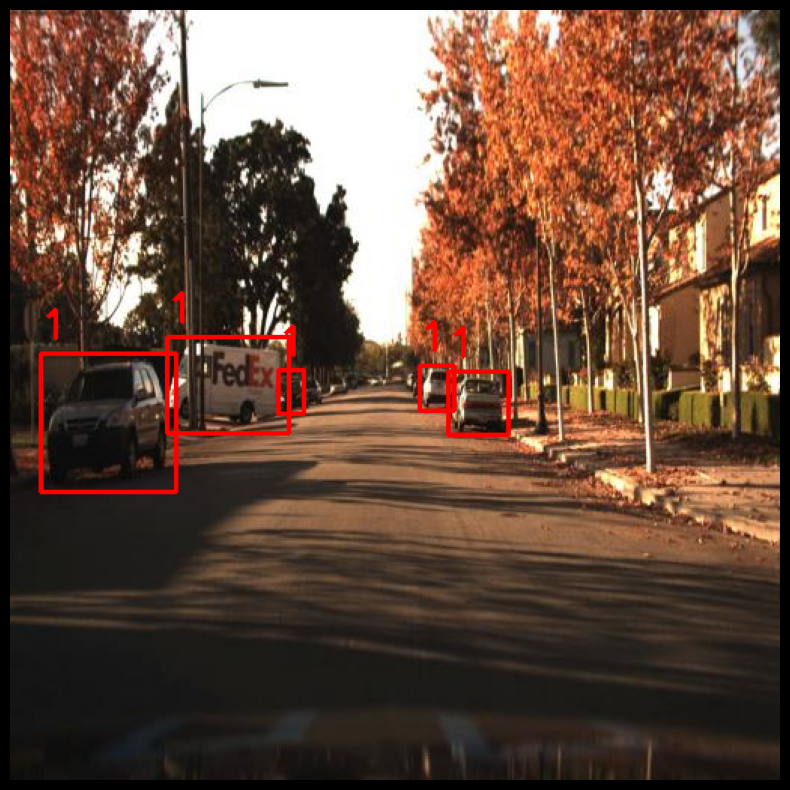

In [40]:
img_tensor, _ = val_dataset[123]

predicted_target = predict(model, img_tensor, device, confidence_threshold=0.7)

print("Предсказанные объекты:")
visualize_sample(img_tensor, predicted_target)